# PD Model Machine Learning Case Study:
## Model Development Section
### Ali Enver Arslan

In [2]:
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import sklearn.metrics as met
from datetime import datetime
import category_encoders as ce 
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,  LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer    
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as impPipeline
from sklearn.base import BaseEstimator, TransformerMixin
from myfunctions import CustomImputer, FeatureCategorizer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, RobustScaler, StandardScaler, MinMaxScaler, KBinsDiscretizer

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_csv("dataset.csv", sep=";")
df.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,20,12.692308,8.333333,Dietary supplements,Health & Beauty,True,31638.0,31638.0,no_match,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,Books & Magazines,Entertainment,True,13749.0,13749.0,F+L,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22,20.000000,18.000000,Diversified entertainment,Entertainment,True,29890.0,29890.0,L1+F,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,True,40040.0,40040.0,F1+L,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,25,13.000000,13.000000,Electronic equipment & Related accessories,Electronics,True,7100.0,7100.0,F+L,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611,NaN


In [4]:
#Convert the boolean value to binary
df["has_paid"] = df["has_paid"].map({True:1, False:0})

train, test = df[~df["default"].isnull()], df[df["default"].isnull()]
test_ids = test["uuid"]
train.drop("uuid", inplace=True, axis=1)
test.drop("uuid", inplace=True, axis=1)
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

X = train.drop("default", axis=1)
y = train["default"]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)

print("Train Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Default Rate in Modelling Data:", round(sum(y)/len(y), 4))
print("Default Rate in Train Set:", round(sum(y_train)/len(y_train), 4))
print("Default Rate in Validation Set:", round(sum(y_val)/len(y_val), 4))

Train Shape: (89976, 42)
Test Shape: (10000, 42)
Train Set Shape: (67482, 41)
Validation Set Shape: (22494, 41)
Default Rate in Modelling Data: 0.0143
Default Rate in Train Set: 0.0143
Default Rate in Validation Set: 0.0143


In [5]:
with open('qualified_features.pkl', 'rb') as f:
    qualified_features = pickle.load(f)

In [6]:
#Categorize the features
cat_cols, ord_cols, num_cols = FeatureCategorizer(X_train)
#Categorize only the qualified features
cat_qlfd, ord_qlfd, num_qlfd = FeatureCategorizer(X_train[qualified_features])

In [7]:
#Impute missing values with predetermined values in the EDA stage
X_train_imputed = CustomImputer(X_train, num_cols, ord_cols, cat_cols)
X_val_imputed = CustomImputer(X_val, num_cols, ord_cols, cat_cols)

#Impute only the selected features after correlation analysis
X_train_qua_imputed = CustomImputer(X_train[qualified_features], num_qlfd, ord_qlfd, cat_qlfd)
X_val_qua_imputed = CustomImputer(X_val[qualified_features], num_qlfd, ord_qlfd, cat_qlfd)

In [8]:
#Define a function for presenting the model results

def performancePredict(X_train, X_val, y_train, y_val, y_train_preds, y_val_preds, predictor): 
    import sklearn.metrics as met
    train_probs = predictor.predict_proba(X_train)
    train_probs  =[prob[1] for prob in train_probs]

    val_probs = predictor.predict_proba(X_val)
    val_probs  =[prob[1] for prob in val_probs]
    
    print("Accuracy Score for Train Set:", met.accuracy_score(y_train, y_train_preds))
    print("ROC-AUC Score for Train Set:", met.roc_auc_score(y_train, train_probs, average="weighted"))
    print("F1 Score for Train Set:", met.f1_score(y_train, y_train_preds))
    print("Recall Score for Train Set:", met.recall_score(y_train, y_train_preds))
    fpr, tpr, thresholds = met.roc_curve(y_train, train_probs)
    auc = met.auc(fpr, tpr)
    print("Gini Score for Train Set:", 2*auc - 1)
    
    print()
    
    print(met.classification_report(y_train, y_train_preds, digits=3))

    print("="*50)

    print("Accuracy Score for Validation Set:", met.accuracy_score(y_val, y_val_preds))
    print("ROC-AUC Score for Validation Set:", met.roc_auc_score(y_val, val_probs, average="weighted"))
    print("F1 Score for Validation Set:", met.f1_score(y_val, y_val_preds))
    print("Recall Score for Validation Set:", met.recall_score(y_val, y_val_preds))
    fpr, tpr, thresholds = met.roc_curve(y_val, val_probs)
    auc = met.auc(fpr, tpr)
    print("Gini Score for Validation Set:", 2*auc - 1)
    
    print()
    
    print(met.classification_report(y_val, y_val_preds, digits=3))
    sns.heatmap(met.confusion_matrix(y_val, y_val_preds), annot=True, fmt=".0f")
    plt.title("Confusion Matrix for Validation Set")
    plt.ylabel('Actual')
    plt.xlabel('Predicted');
    
    print()
    
    met.plot_roc_curve(predictor, X_val, y_val)
    plt.title("ROC Curve for Validation Set", fontsize=12);
        
    print()
    
    def getClassifierName(X):
        if hasattr(X, 'estimator'):
            return X.estimator.steps[1][1].__class__.__name__
        else:
            return X.__class__.__name__
    
    met.plot_precision_recall_curve(predictor, X_val, y_val, name = getClassifierName(predictor))
    plt.title("Precision - Recall Curve for Validation Set", fontsize=12);

**Model 1: Logistic Regression as a Baseline with All Features Included**

Baseline model is Logistic Regression with its built in default parameters. 

For the preprocessing phase, one hot encoder is used for categorical feature encoding, while numeric features are scaled with Standard Scaling method and ordinal features are left as they are. 

Accuracy Score for Train Set: 0.9853738774784387
ROC-AUC Score for Train Set: 0.8991331745147761
F1 Score for Train Set: 0.07149576669802446
Recall Score for Train Set: 0.039337474120082816
Gini Score for Train Set: 0.7982663490295523

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     66516
         1.0      0.392     0.039     0.071       966

    accuracy                          0.985     67482
   macro avg      0.689     0.519     0.532     67482
weighted avg      0.978     0.985     0.979     67482

Accuracy Score for Validation Set: 0.9855517026762692
ROC-AUC Score for Validation Set: 0.8910869621244635
F1 Score for Validation Set: 0.05247813411078717
Recall Score for Validation Set: 0.027950310559006212
Gini Score for Validation Set: 0.782173924248927

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     22172
         1.0      0.429     0.028     0.052       322

    accuracy 

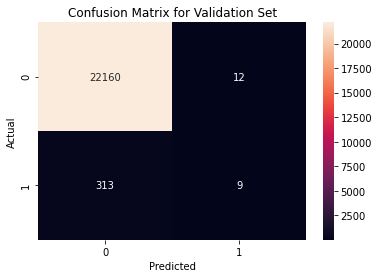

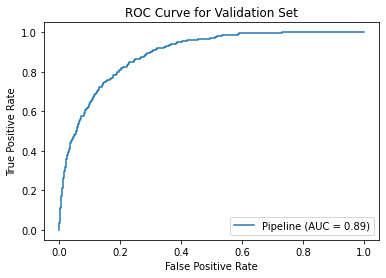

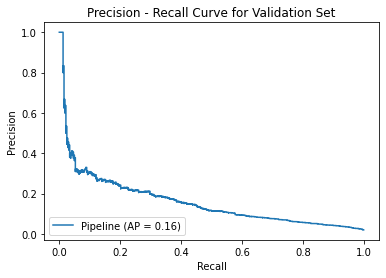

In [28]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)], remainder="passthrough")

model1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=3000, random_state=42))])

model1.fit(X_train_imputed, y_train)
y_tr_preds1 = model1.predict(X_train_imputed)
y_val_preds1 = model1.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, y_tr_preds1, y_val_preds1, model1)

**Model 2: Logistic Regression with only selected features**

Model 2 is Logistic Regression with its built in default parameters.

In the preprocessing phase same procedure is followed except that only the features passed from the correlation elimination are used in the model. One hot encoder is used for categorical feature encoding, while numeric features are scaled with Standard Scaling method and ordinal features are left as they are.

Accuracy Score for Train Set: 0.9851219584481787
ROC-AUC Score for Train Set: 0.8815507985936415
F1 Score for Train Set: 0.038314176245210725
Recall Score for Train Set: 0.020703933747412008
Gini Score for Train Set: 0.763101597187283

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     66516
         1.0      0.256     0.021     0.038       966

    accuracy                          0.985     67482
   macro avg      0.621     0.510     0.515     67482
weighted avg      0.976     0.985     0.979     67482

Accuracy Score for Validation Set: 0.9854627900773539
ROC-AUC Score for Validation Set: 0.8772322654167362
F1 Score for Validation Set: 0.035398230088495575
Recall Score for Validation Set: 0.018633540372670808
Gini Score for Validation Set: 0.7544645308334723

              precision    recall  f1-score   support

         0.0      0.986     1.000     0.993     22172
         1.0      0.353     0.019     0.035       322

    accurac

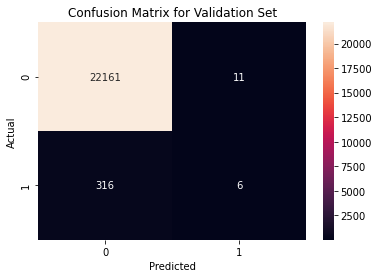

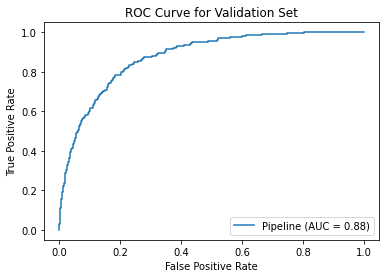

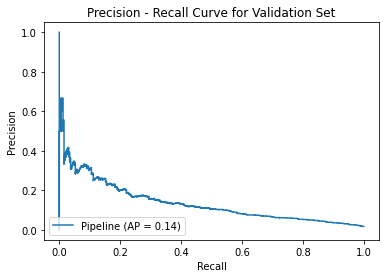

In [29]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_qlfd),
        ('cat', categorical_transformer, cat_qlfd)], remainder="passthrough")

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=2500, random_state=42))])

model2.fit(X_train_qua_imputed, y_train)

y_tr_preds2 = model2.predict(X_train_qua_imputed)
y_val_preds2 = model2.predict(X_val_qua_imputed)

performancePredict(X_train_qua_imputed, X_val_qua_imputed, y_train, y_val, y_tr_preds2, y_val_preds2, model2)

**Model 3: Logistic Regression with All Features Included Except the Cagetorical Ones**

Model 3 is Logistic Regression with its built in default parameters.

In the preprocessing phase same procedure is followed except that categorical features are excluded due to high cardinality from the model. Numeric features are scaled with Standard Scaling method and ordinal features are left as they are.

Accuracy Score for Train Set: 0.9854035150114104
ROC-AUC Score for Train Set: 0.8820970175204658
F1 Score for Train Set: 0.0446168768186227
Recall Score for Train Set: 0.023809523809523808
Gini Score for Train Set: 0.7641940350409315

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     66516
         1.0      0.354     0.024     0.045       966

    accuracy                          0.985     67482
   macro avg      0.670     0.512     0.519     67482
weighted avg      0.977     0.985     0.979     67482

Accuracy Score for Validation Set: 0.9857295278740997
ROC-AUC Score for Validation Set: 0.8831813781132938
F1 Score for Validation Set: 0.05865102639296187
Recall Score for Validation Set: 0.031055900621118012
Gini Score for Validation Set: 0.7663627562265876

              precision    recall  f1-score   support

         0.0      0.986     1.000     0.993     22172
         1.0      0.526     0.031     0.059       322

    accuracy 

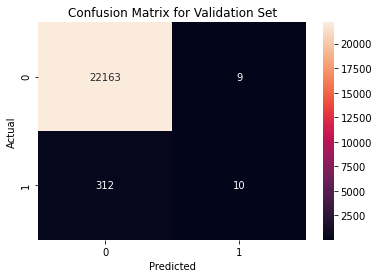

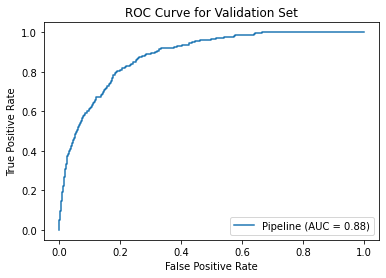

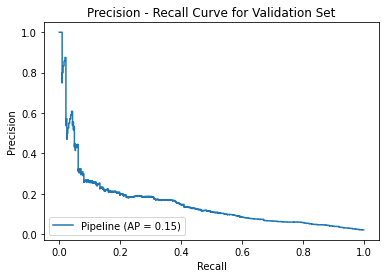

In [30]:
numeric_transformer = StandardScaler()

#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_cols)], remainder="passthrough")

model3 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=2500, random_state=42))])

non_categoric_features = num_cols + ord_cols
model3.fit(X_train_imputed[non_categoric_features], y_train)

y_tr_preds3 = model3.predict(X_train_imputed[non_categoric_features])
y_val_preds3 = model3.predict(X_val_imputed[non_categoric_features])

performancePredict(X_train_imputed[non_categoric_features], X_val_imputed[non_categoric_features], y_train, y_val, y_tr_preds3, y_val_preds3, model3)

So far the best model is the model 3. We will investigate the model probability threshold and try to get a better result

**Model 4: Logistic Regression with All Features Included Except the Cagetorical Ones and Opimized Threshold**

Model 4 is Logistic Regression with its built in default parameters.

In the preprocessing phase same procedure is followed except that categorical features are excluded due to high cardinality from the model. Numeric features are scaled with Standard Scaling method and ordinal features are left as they are. For the prediction task, threshold optimization is also implemented.

Optimal threshold: 0.019
Accuracy Score for Train Set: 0.8101864200823924
ROC-AUC Score for Train Set: 0.8820970175204658
F1 Score for Train Set: 0.10582897033158814
Recall Score for Train Set: 0.7846790890269151
Gini Score for Train Set: 0.7641940350409315

              precision    recall  f1-score   support

         0.0      0.996     0.811     0.894     66516
         1.0      0.057     0.785     0.106       966

    accuracy                          0.810     67482
   macro avg      0.526     0.798     0.500     67482
weighted avg      0.983     0.810     0.883     67482

Accuracy Score for Validation Set: 0.8091046501289233
ROC-AUC Score for Validation Set: 0.8831813781132938
F1 Score for Validation Set: 0.10764754779717374
Recall Score for Validation Set: 0.8043478260869565
Gini Score for Validation Set: 0.7663627562265876

              precision    recall  f1-score   support

         0.0      0.997     0.809     0.893     22172
         1.0      0.058     0.804     0.108   

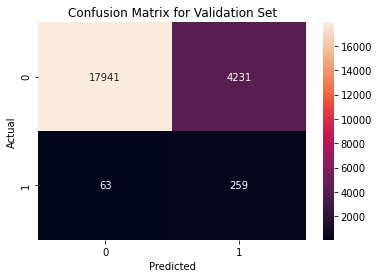

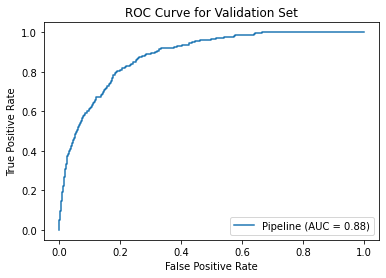

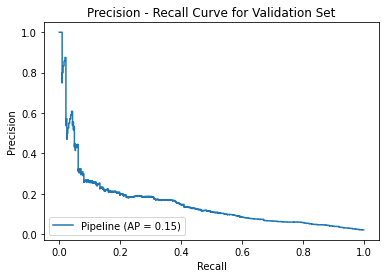

In [31]:
train3_probs = model3.predict_proba(X_train_imputed[non_categoric_features])
train3_probs = [prob[1] for prob in train3_probs]

val3_probs = model3.predict_proba(X_val_imputed[non_categoric_features])
val3_probs = [prob[1] for prob in val3_probs]

fpr, tpr, thresholds = met.roc_curve(y_val, val3_probs)
auc = met.auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", round(optimal_threshold, 4))

manuel_preds_train = []
for probs in train3_probs:
    if probs >= optimal_threshold:
        manuel_preds_train.append(1)
    else:
        manuel_preds_train.append(0)

manuel_preds_val = []
for probs in val3_probs:
    if probs >= optimal_threshold:
        manuel_preds_val.append(1)
    else:
        manuel_preds_val.append(0)

performancePredict(X_train_imputed[non_categoric_features], X_val_imputed[non_categoric_features], y_train, y_val, manuel_preds_train, manuel_preds_val, model3)

**Model 5: Tuning via the Data Preprocessing Optimization**

In [9]:
#For keeping the data as it is
class AsIsReturner(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        return X

    def transform(self, X, y=None):
        return X
    
#For selecting the best scaler 
class ScalerSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X, y=None):
        return self.scaler.fit(X)

    def transform(self, X, y=None):
        return self.scaler.transform(X)
    
#For selecting the best encoder    
class EncoderSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoder=ce.OneHotEncoder(use_cat_names=True)):
        super().__init__()
        self.encoder = encoder

    def fit(self, X, y):
        return self.encoder.fit(X, y)   

    def transform(self, X, y=None):
        return self.encoder.transform(X)    

#For selecting the best bining method
class BiningSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, bining=KBinsDiscretizer(n_bins=4, encode='onehot-dense')):
        super().__init__()
        self.bining = bining

    def fit(self, X, y=None):
        return self.bining.fit(X)

    def transform(self, X, y=None):
        return self.bining.transform(X)    
        

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 14.9min finished


Best parameters:
 {'preprocessor__bin__bining': MinMaxScaler(copy=True, feature_range=(0, 1)), 'preprocessor__multicategory__encoder': WOEEncoder(cols=None, drop_invariant=False, handle_missing='value',
           handle_unknown='value', random_state=None, randomized=False,
           regularization=1.0, return_df=True, sigma=0.05, verbose=0), 'preprocessor__numerical__scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'preprocessor__ordinal__scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

Accuracy Score for Train Set: 0.985447971310868
ROC-AUC Score for Train Set: 0.8966063303064927
F1 Score for Train Set: 0.07007575757575757
Recall Score for Train Set: 0.038302277432712216
Gini Score for Train Set: 0.7932126606129855

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     66516
         1.0      0.411     0.038     0.070       966

    accuracy                          0.985     67482
   macro avg      0.699    

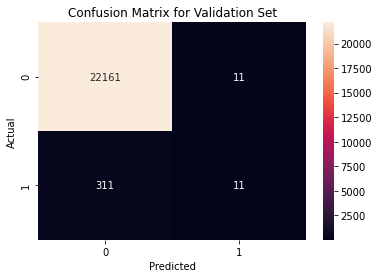

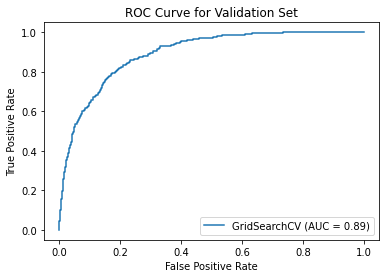

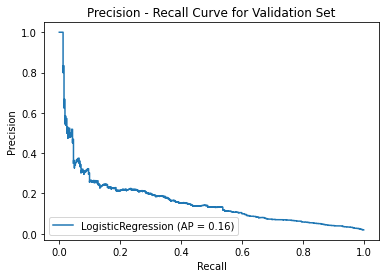

In [77]:
# scaler, encoder and bining options
my_scaler = ScalerSelector()
my_encoder = EncoderSelector()
my_bining = BiningSelector()


multicategorycols = [col for col in cat_cols if X_train[col].nunique() >= 4]
lowcategorycols = [col for col in cat_cols if X_train[col].nunique() < 4]
num_cols2 = num_cols.copy()
num_cols2.remove("age")
age_col = ["age"]


preprocessor = ColumnTransformer(transformers = [('numerical', my_scaler, num_cols2),
                                                 ('multicategory', my_encoder, multicategorycols),                                
                                                 ('ordinal', my_scaler, ord_cols),
                                                 ("bin", my_bining, age_col)
                                                ], remainder="passthrough")


# combine the preprocessor with LogisticRegression() using Pipeline 
model5 = Pipeline(steps = [('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=3500, random_state=42))
                          ])

# set params combinations
scaler_encoder_options = {'preprocessor__numerical__scaler':[StandardScaler(), RobustScaler(), MinMaxScaler()],
                          'preprocessor__multicategory__encoder': [ce.OneHotEncoder(use_cat_names=True), ce.TargetEncoder(), ce.WOEEncoder()],
                          'preprocessor__ordinal__scaler': [StandardScaler(), MinMaxScaler(), AsIsReturner()],
                          'preprocessor__bin__bining': [ MinMaxScaler(), KBinsDiscretizer(n_bins=4, encode='onehot-dense'), AsIsReturner()]
                          }



# initialize GridSearchCV using full_pipeline as final estimator
grid1 = GridSearchCV(model5, param_grid = scaler_encoder_options, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1)
grid1.fit(X_train_imputed, y_train)
print("Best parameters:\n", grid1.best_params_)
print()
trainpreds5 = grid1.predict(X_train_imputed)
valpreds5 = grid1.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, trainpreds5, valpreds5, grid1)

**Multiple Model Comparison**

In [13]:
#Build a multiple model comparison function

def MultiModelComparator(X_train, y_train, X_val, y_val):
    rand_state = 42
    rfc = RandomForestClassifier(random_state=rand_state)
    abc = AdaBoostClassifier(random_state=rand_state)
    bc = BaggingClassifier(random_state=rand_state)
    etc = ExtraTreesClassifier(random_state=rand_state)
    gbc = GradientBoostingClassifier(random_state=rand_state)
    lrc = LogisticRegression(max_iter=3500, random_state=rand_state)
    svc = SVC(probability=True, random_state=rand_state)
    xgb = XGBClassifier(random_state=rand_state)
    
    roc_auc_results = {}
    f2_scores = {}
    f1_scores = {}
    recall_scores = {}
    precision_scores = {}
    accuracy_scores = {}
    runtime = {}
    for classifier in [rfc, abc, bc, etc, gbc, lrc, svc, xgb]:
        start_time = datetime.now()
        model6 = Pipeline(steps = [('preprocessor', grid1.best_estimator_.named_steps['preprocessor']),
                                   ('classifier', classifier)
                                  ])
        model6.fit(X_train, y_train)
     
        val_probs = model6.predict_proba(X_val)    
        val_pred = model6.predict(X_val)
        val_probs  =[prob[1] for prob in val_probs]
        roc_auc_results[classifier.__class__.__name__] = met.roc_auc_score(y_val, val_probs, average="weighted")
        f2_scores[classifier.__class__.__name__] = met.fbeta_score(y_val, val_pred, beta=2, labels=np.unique(val_pred))
        f1_scores[classifier.__class__.__name__] = met.f1_score(y_val, val_pred, labels=np.unique(val_pred))
        recall_scores[classifier.__class__.__name__] = met.recall_score(y_val, val_pred, labels=np.unique(val_pred))
        precision_scores[classifier.__class__.__name__] = met.precision_score(y_val, val_pred, labels=np.unique(val_pred))
        accuracy_scores[classifier.__class__.__name__] = met.accuracy_score(y_val, val_pred)
        
        end_time = datetime.now()
        runtime[classifier.__class__.__name__] = (end_time - start_time).seconds
        
    roc_auc_df =  pd.DataFrame.from_dict(roc_auc_results, orient="index").rename(columns={0:"ROC_AUC"})
    f1_df = pd.DataFrame.from_dict(f1_scores, orient="index").rename(columns={0:"F1"})
    f2_df = pd.DataFrame.from_dict(f2_scores, orient="index").rename(columns={0:"F2"})
    recall_df = pd.DataFrame.from_dict(recall_scores, orient="index").rename(columns={0:"Recall"})
    precision_df = pd.DataFrame.from_dict(precision_scores, orient="index").rename(columns={0:"Precision"})
    accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient="index").rename(columns={0:"Accuracy"})
    runtime_df = pd.DataFrame.from_dict(runtime, orient="index").rename(columns={0:"Runtime_in_sec"})
    
    
    result_df = pd.concat([roc_auc_df, f1_df, f2_df, recall_df, precision_df, accuracy_df, runtime_df], axis=1)
    return result_df

modelcomparisondf = MultiModelComparator(X_train_imputed, y_train, X_val_imputed, y_val)        
display(modelcomparisondf)

,ROC_AUC,F1,F2,Recall,Precision,Accuracy,Runtime_in_sec
RandomForestClassifier,0.848419,0.126722,0.086531,0.071429,0.560976,0.985907,14
AdaBoostClassifier,0.891303,0.104478,0.076754,0.065217,0.262500,0.983996,10
BaggingClassifier,0.743103,0.177546,0.126019,0.105590,0.557377,0.985996,12
ExtraTreesClassifier,0.819525,0.188862,0.141407,0.121118,0.428571,0.985107,10
GradientBoostingClassifier,0.902177,0.117962,0.082151,0.068323,0.431373,0.985374,40
LogisticRegression,0.890923,0.069565,0.045767,0.037267,0.521739,0.985730,23
SVC,0.527352,0.000000,0.000000,0.000000,0.000000,0.985685,264
XGBClassifier,0.907999,0.087209,0.057252,0.046584,0.681818,0.986041,12


So far, we have worked on deciding which features to use, which preprocessing methods to use and by using our best preprocessing methods combined we compared multiple algorithms and aim at continuing with the best one for further improvements. 

From the comparison of different algorithms, *XGBoost* has the best AUC score and *Logistic Regression* is on the top of the list. We will continue with these two algotihms for further improvements. We will first run our preprocessing optimization pipeline with our selected algorithm and choose the best one. Then we will try to use if there will be an improvement when using over-sampling methods.

Afterwards, we will fine tune our best model and select the best hyperparameters to use.

**Preprocessing Tuning of the XGBoost Classifier**

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  8.2min finished


Best parameters:
 {'preprocessor__bin__bining': MinMaxScaler(copy=True, feature_range=(0, 1)), 'preprocessor__multicategory__encoder': WOEEncoder(cols=None, drop_invariant=False, handle_missing='value',
           handle_unknown='value', random_state=None, randomized=False,
           regularization=1.0, return_df=True, sigma=0.05, verbose=0), 'preprocessor__numerical__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'preprocessor__ordinal__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

Accuracy Score for Train Set: 0.9863519160665066
ROC-AUC Score for Train Set: 0.9274432344427599
F1 Score for Train Set: 0.11186113789778207
Recall Score for Train Set: 0.060041407867494824
Gini Score for Train Set: 0.8548864688855198

              precision    recall  f1-score   support

         0.0      0.987     1.000     0.993     66516
         1.0      0.817     0.060     0.112       966

    accuracy                          0.986     67482
   macro avg      0.902   

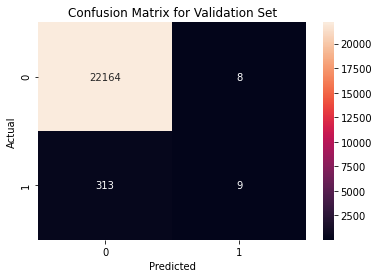

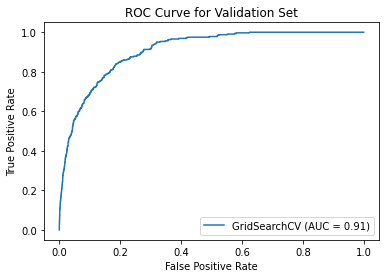

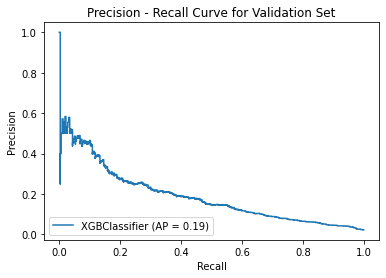

In [10]:
# scaler, encoder and bining options
my_scaler = ScalerSelector()
my_encoder = EncoderSelector()
my_bining = BiningSelector()

#we keep the 3 and less unique values in low category since there is only one
#feature that has 3 unique values and it is only one instance.

multicategorycols = [col for col in cat_cols if X_train[col].nunique() >= 4]
lowcategorycols = [col for col in cat_cols if X_train[col].nunique() < 4]
num_cols2 = num_cols.copy()
num_cols2.remove("age")
age_col = ["age"]


preprocessor = ColumnTransformer(transformers = [('numerical', my_scaler, num_cols2),
                                                 ('multicategory', my_encoder, multicategorycols),
                                                 ('ordinal', my_scaler, ord_cols),
                                                 ("bin", my_bining, age_col)
                                                ], remainder="passthrough")


# combine the preprocessor with XGBClassifier() using Pipeline 
model7 = Pipeline(steps = [('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
                          ])

# set params combinations
scaler_encoder_options = {'preprocessor__numerical__scaler':[StandardScaler(), RobustScaler(), MinMaxScaler()],
                          'preprocessor__multicategory__encoder': [ce.OneHotEncoder(use_cat_names=True), ce.TargetEncoder(), ce.WOEEncoder()],
                          'preprocessor__ordinal__scaler': [StandardScaler(), MinMaxScaler(), AsIsReturner()],
                          'preprocessor__bin__bining': [ MinMaxScaler(), KBinsDiscretizer(n_bins=4, encode='onehot-dense'), AsIsReturner()]
                          }



# initialize GridSearchCV using full_pipeline as final estimator
grid2 = GridSearchCV(model7, param_grid = scaler_encoder_options, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1)
grid2.fit(X_train_imputed, y_train)
print("Best parameters:\n", grid2.best_params_)
print()
trainpreds7 = grid2.predict(X_train_imputed)
valpreds7 = grid2.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, trainpreds7, valpreds7, grid2)

**Parameter Tuning of the XGBoost Classifier**

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.7min finished


Best parameters:
 {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}

Accuracy Score for Train Set: 0.9872114045226875
ROC-AUC Score for Train Set: 0.9404806259662365
F1 Score for Train Set: 0.20460829493087557
Recall Score for Train Set: 0.11490683229813664
Gini Score for Train Set: 0.880961251932473

              precision    recall  f1-score   support

         0.0      0.987     1.000     0.994     66516
         1.0      0.933     0.115     0.205       966

    accuracy                          0.987     67482
   macro avg      0.960     0.557     0.599     67482
weighted avg      0.987     0.987     0.982     67482

Accuracy Score for Validation Set: 0.9860851782697608
ROC-AUC Score for Validation Set: 0.9111973105802964
F1 Score for Validation Set: 0.09798270893371758
Recall Score for Validation Set: 0.052795031055900624
Gini Score for Validation Set: 0.8223946211605928

              precision    recall  f

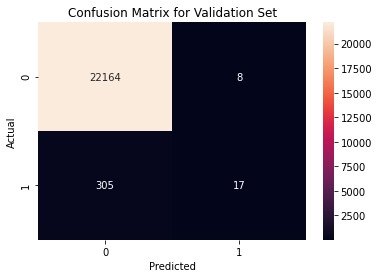

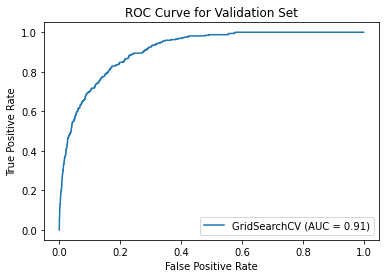

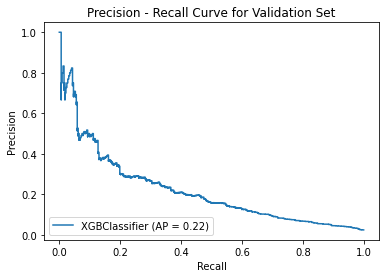

In [11]:
model8 = Pipeline(steps = [('preprocessor', grid2.best_estimator_.named_steps['preprocessor']),
                           ('classifier', XGBClassifier(objective='binary:logistic',random_state=42))
                          ])


# set params combinations
params1 = {'classifier__n_estimators':[100],
           'classifier__learning_rate':[0.01, 0.1],
           'classifier__max_depth':[3, 4],  
           'classifier__gamma':[0, 0.01, 0.1]
           }

# initialize GridSearchCV using full_pipeline as final estimator
kfold_ = StratifiedKFold(n_splits=3, shuffle=False)
grid3 = GridSearchCV(model8, param_grid = params1, scoring='roc_auc', cv=kfold_, n_jobs=-1, verbose=1 )
grid3.fit(X_train_imputed, y_train)
print("Best parameters:\n", grid3.best_params_)
print()
trainpreds8 = grid3.predict(X_train_imputed)
valpreds8 = grid3.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, trainpreds8, valpreds8, grid3)

**Parameter Tuning of the Logistic Regression**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


Best parameters:
 {'classifier__C': 0.5, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Accuracy Score for Train Set: 0.9855220651432974
ROC-AUC Score for Train Set: 0.8964962523377368
F1 Score for Train Set: 0.06863679694947569
Recall Score for Train Set: 0.037267080745341616
Gini Score for Train Set: 0.7929925046754736

              precision    recall  f1-score   support

         0.0      0.986     0.999     0.993     66516
         1.0      0.434     0.037     0.069       966

    accuracy                          0.986     67482
   macro avg      0.710     0.518     0.531     67482
weighted avg      0.978     0.986     0.979     67482

Accuracy Score for Validation Set: 0.9857295278740997
ROC-AUC Score for Validation Set: 0.8927123124347983
F1 Score for Validation Set: 0.0641399416909621
Recall Score for Validation Set: 0.034161490683229816
Gini Score for Validation Set: 0.7854246248695966

              precision    recall  f1-score   support

         0.0    

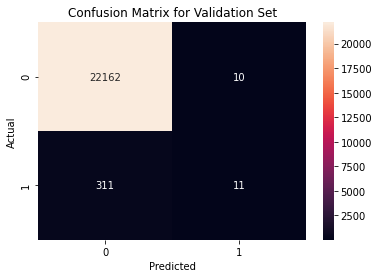

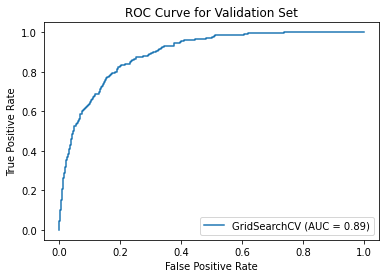

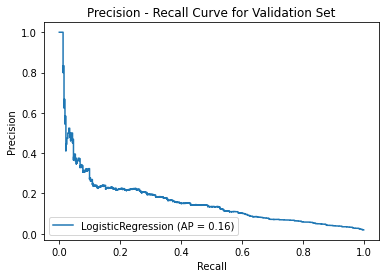

In [82]:
model9 = Pipeline(steps = [('preprocessor', grid1.best_estimator_.named_steps['preprocessor']),
                           ('classifier', LogisticRegression(random_state=42))
                          ])



# set params combinations
params2 = [{'classifier__C'      : np.arange(0, 1.0, 0.5), 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga']},
          
          {'classifier__C'      : np.arange(0, 1.0, 0.5), 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear','lbfgs','saga']}
         ]


# initialize GridSearchCV using full_pipeline as final estimator
kfold_ = StratifiedKFold(n_splits=3, shuffle=False)
grid4 = GridSearchCV(model9, param_grid = params2, scoring='roc_auc', cv=kfold_, n_jobs=-1, verbose=1 )
grid4.fit(X_train_imputed, y_train)
print("Best parameters:\n", grid4.best_params_)
print()
trainpreds9 = grid4.predict(X_train_imputed)
valpreds9 = grid4.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, trainpreds9, valpreds9, grid4)

**Predict the unseen data**

In [33]:
#Impute missing values with predetermined values in the EDA stage
Xtest_imputed = CustomImputer(test, num_cols, ord_cols, cat_cols)

predictions = grid3.best_estimator_.predict_proba(Xtest_imputed)
predictions = [prob[1] for prob in predictions]
predictions = pd.concat([test_ids.reset_index(), pd.Series(predictions)], axis=1, ignore_index=True)
predictions = predictions[[1, 2]]
predictions = predictions.rename(columns={1:"uuid", 2: "pd"})
predictions.to_csv("test_predictions.csv",index=False)

In [ ]:
from google.colab import files
files.download('test_predictions.csv') 

**Over Sampling with SMOTE**

We improved our model so far model comparison, preprocessing and hyperparameter optimization. But since our data is highly imbalanced, it is better to try a sampling algorithm to see if there is an improvement.

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


Best parameters:
 {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'sampling__k_neighbors': 3, 'sampling__m_neighbors': 5, 'sampling__sampling_strategy': 'minority'}

Accuracy Score for Train Set: 0.7510447230372543
ROC-AUC Score for Train Set: 0.7260198887996189
F1 Score for Train Set: 0.06625166740773676
Recall Score for Train Set: 0.6169772256728778
Gini Score for Train Set: 0.45203977759923775

              precision    recall  f1-score   support

         0.0      0.993     0.753     0.856     66516
         1.0      0.035     0.617     0.066       966

    accuracy                          0.751     67482
   macro avg      0.514     0.685     0.461     67482
weighted avg      0.979     0.751     0.845     67482

Accuracy Score for Validation Set: 0.7473548501822709
ROC-AUC Score for Validation Set: 0.7318859022010863
F1 Score for Validation Set: 0.06637095449318219
Recall Score for Validation Set: 0.62732

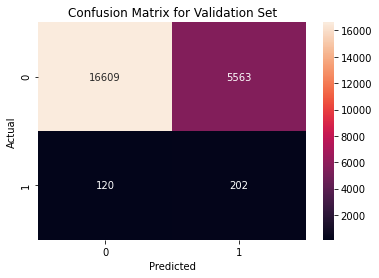

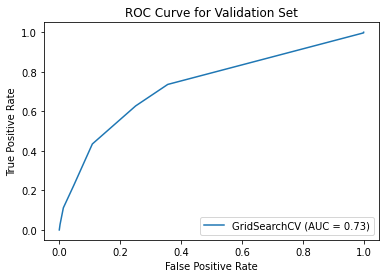

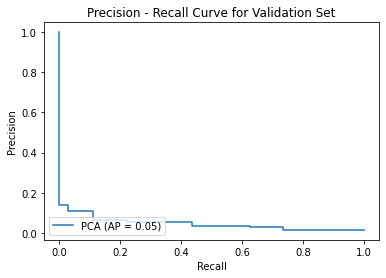

In [20]:
from sklearn.decomposition import PCA
model10 = impPipeline(steps = [('preprocessor', grid2.best_estimator_.named_steps['preprocessor']),
                               ('pca', PCA(n_components=0.9)),
                               ("sampling", SMOTE(n_jobs=-1, random_state=42)),
                               ('classifier', XGBClassifier(objective='binary:logistic',random_state=42))
                          ])

# set params combinations
params3 = {'classifier__n_estimators':[grid3.best_params_["classifier__n_estimators"]],
           'classifier__learning_rate':[0.01, 0.1],
           'classifier__max_depth':[grid3.best_params_["classifier__max_depth"]],  
           'classifier__gamma':[grid3.best_params_["classifier__gamma"]],
           'sampling__sampling_strategy':['minority', 'all'],          
           'sampling__k_neighbors':[3, 5], 
           'sampling__m_neighbors': [5, 10]               
         }

# initialize GridSearchCV using full_pipeline as final estimator
kfold_ = StratifiedKFold(n_splits=3, shuffle=False)
grid5 = GridSearchCV(model10, param_grid = params3, scoring='f1', cv=kfold_, n_jobs=-1, verbose=1 )
grid5.fit(X_train_imputed, y_train)
print("Best parameters:\n", grid5.best_params_)
print()
trainpreds10 = grid5.predict(X_train_imputed)
valpreds10 = grid5.predict(X_val_imputed)

performancePredict(X_train_imputed, X_val_imputed, y_train, y_val, trainpreds10, valpreds10, grid5)

Over sampling did perform worse than the other models. SMOTE is known poor performer model when data is high dimensional. So this is not a surprise for us. Although we decreased the dimension via Principal Component Analysis, we may try different oversampling or undersampling techniques to have a better performance. 

In [ ]:
import joblib
best_model = grid3.best_estimator_


joblib.dump(best_model, 'best_pd_model.pkl')    